# Generating Text Using HMMs

In this notebook, we will use the Treebank dataset to train an HMM model capable of anotating a given text with its Part-of-Speech (POS) tags first. Then we use this same model to generate text. Treebank is a dataset maintained by the University of Pennsylvania with over four million and eight hundred thousand annotated words in it.

In [1]:
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

random.seed(123456)

In [2]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

## Load and prepare data

Let's load the treebank dataset

In [3]:
wsj = list(nltk.corpus.treebank.tagged_sents())
print(wsj[1])

[('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'NNP'), ('publishing', 'VBG'), ('group', 'NN'), ('.', '.')]


Splitting into train and test

In [4]:
train_set, test_set = train_test_split(wsj,test_size=0.3)

print(len(train_set))
print(len(test_set))

2739
1175


We will loop over each sentence and the words in a sentence to get a list of the (word,tag) tuples:

In [5]:
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

70756

Let's generate the set of words (vocabulary):

In [6]:
tokens = [pair[0] for pair in train_tagged_words]
V = set(tokens)
print("Number of wordsin the vocabulary: ",len(V))


Number of wordsin the vocabulary:  10170


Let's generate the set of POS tags:

In [7]:
T = set([pair[1] for pair in train_tagged_words])
print("Total tags: ",len(T))

Total tags:  46


## Generating the Emission Matrix
Now let's generate the emission matrix

First we will count the number of times each tag-word pair appears in the corpus:

In [8]:
from collections import defaultdict

tag_word_count_map=defaultdict(int)
for pair in train_tagged_words:
    tag_word_count_map[pair]+=1

In [9]:
tag_word_count_map[('African', 'JJ')]

1

Below, we sum the total number of words observed for each tag. we will use this to normalize the numbers to probablilites:

In [10]:
tag_words_total_count=defaultdict(int)
for pair in tag_word_count_map.keys():
    tag_words_total_count[pair[1]]+=tag_word_count_map[pair]

In [11]:
tag_words_total_count['DT']

5756

in the final step, we will generate an emission dict. For each tag as a key in the dict we have a dict of words and their probablities:

In [12]:
emission_probs_map=defaultdict(lambda : defaultdict(int))
for pair in tag_word_count_map.keys():
    emission_probs_map[pair[1]][pair[0]]+=(tag_word_count_map[pair]/tag_words_total_count[pair[1]])

In [15]:
emission_probs_map['DT']

defaultdict(int,
            {'the': 0.4947880472550382,
             'a': 0.22915218902015289,
             'no': 0.009555246699096595,
             'This': 0.004517025712300208,
             'an': 0.03717859624739402,
             'these': 0.006949270326615705,
             'each': 0.004517025712300208,
             'neither': 0.0010423905489923557,
             'The': 0.08756080611535788,
             'those': 0.0064280750521195276,
             'A': 0.012334954829742877,
             'this': 0.0236275191104934,
             'That': 0.005038220986796386,
             'Some': 0.001911049339819319,
             'any': 0.013377345378735233,
             'An': 0.002258512856150104,
             'that': 0.009728978457261988,
             'some': 0.014940931202223767,
             'another': 0.005211952744961779,
             'every': 0.002432244614315497,
             'Each': 0.001389854065323141,
             'All': 0.0015635858234885338,
             'These': 0.0026059763724808893,
   

## Generating the Transition Matrix

We will create a t by t transition matrix of tags. tags_matrix(i, j) represents P(tj given ti):

In [18]:

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

# examples
print(t2_given_t1(t2='NNP', t1='JJ'))


(150, 4085)


In [19]:
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]


In [20]:
# convert the matrix to a df
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df = tags_df.astype('float64')

In [21]:
#normalize the values so that each row sums up to 1
tags_df_normalized=tags_df.div(tags_df.sum(axis=1), axis=0)


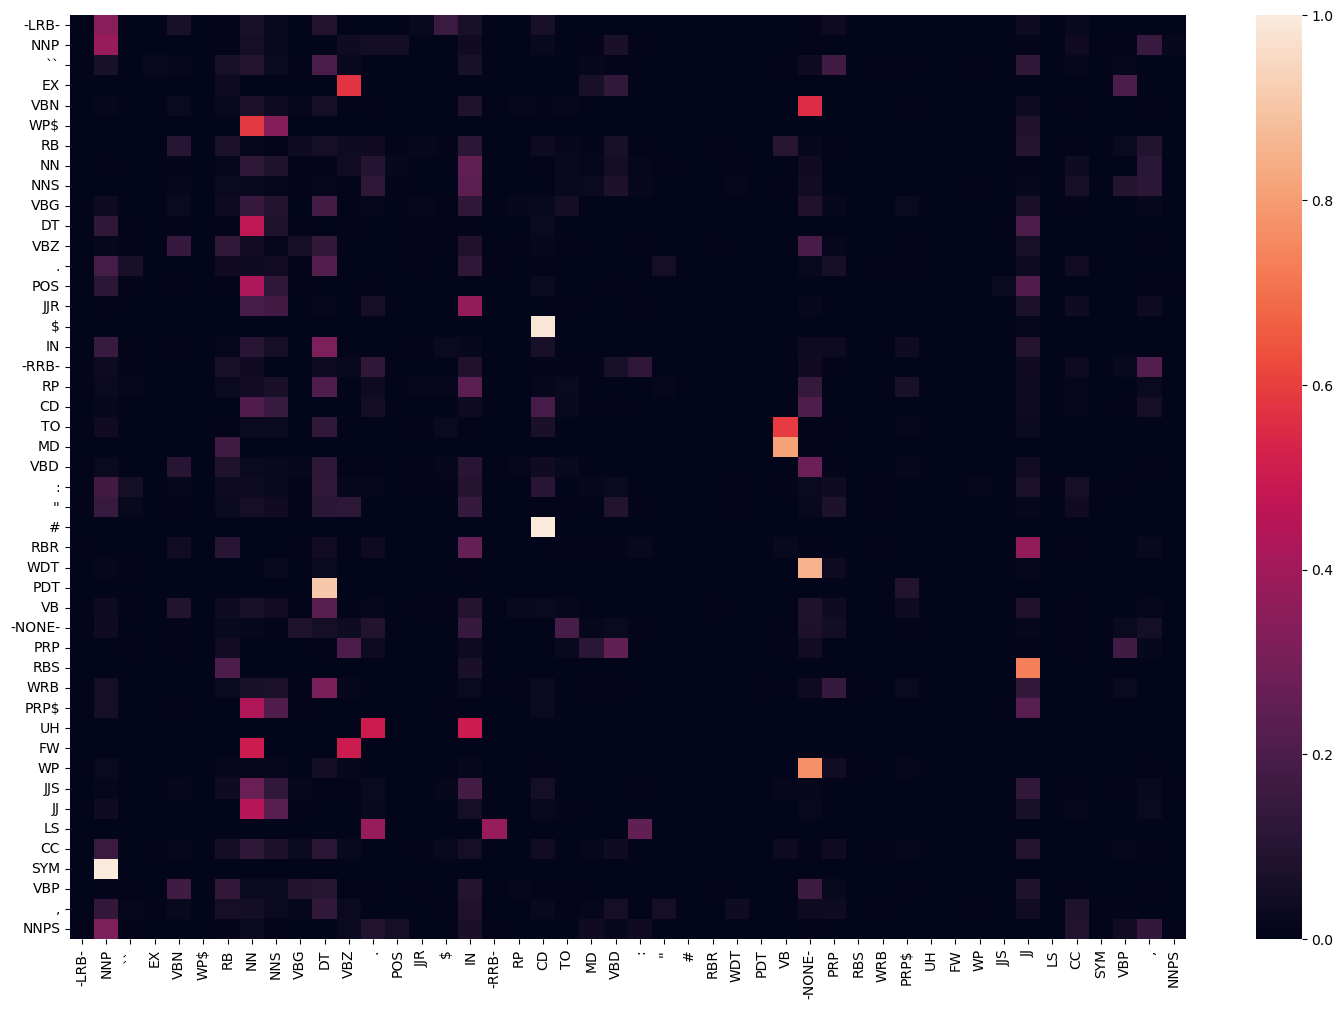

In [22]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

## Text Generation

We will generate a dict showing the possible words for each POS tag to be used in our text generation algorithm below

In [23]:
observations={}
for tup in train_tagged_words:
    if not tup[1] in observations:
        observations[tup[1]]=[tup[0]]
    else:
        observations[tup[1]].append(tup[0])

        
for tag,words in observations.items():
    words_set = set(words)
    unique_words = (list(words_set))
    observations[tag]=unique_words
                   

In [24]:
observations['DT']

['neither',
 'Every',
 'Those',
 'either',
 'This',
 'a',
 'each',
 'These',
 'THE',
 'That',
 'Each',
 'The',
 'Any',
 'an',
 'del',
 'both',
 'Both',
 'no',
 'All',
 'the',
 'Neither',
 'Another',
 'any',
 'those',
 'every',
 'An',
 'another',
 'AN',
 'No',
 'Some',
 'these',
 'all',
 'la',
 'A',
 'half',
 'this',
 'that',
 'some']

The text generation function below starts from a random pos tag provided as input to and tries to compelete a text with the given length as the second input:

In [35]:
def generate_text(start_tag,length):
    states=list(T)
    sequence = []
    state_sequence = []

    # Choose initial state
    current_state = start_tag
    state_sequence.append(current_state)

    # Generate a sequence of the specified length 
    for _ in range(length):
        # Generate an observation
        current_observation = np.random.choice(observations[current_state], p=[emission_probs_map[current_state][k] for k in observations[current_state]])
        sequence.append(current_observation)
        
        # Transition to the next state
        probs=[ tags_df_normalized.loc[current_state, s] for s in states]
        current_state = np.random.choice(states,p=probs )
        state_sequence.append(current_state)
    
    return ' '.join(sequence), state_sequence

In [36]:
# Generate a sentence of length 5
sentence, state_sequence = generate_text('DT',100)
print("Generated sentence:", sentence)
print("State sequence:", state_sequence)

Generated sentence: this plaintiffs -- than a December Charles , were 0 to Sheep , dollar test on dusty % , and did its period , Owner Express shares that critics in Congress made York , a national month *T*-4 to 4.5 instance . since Gulf , were * to use a municipal sensitivity -RRB- : the EST Miami President York Coleman , increased pretax killings that the new plan 's Federal resolution , and problem , '' When psychiatric reaction pressures of $ 1990 65 inefficiencies , the substantial basis and Department Diamond Patrick bonds far world about Group Wall ,
State sequence: ['DT', 'NNS', ':', 'IN', 'DT', 'NNP', 'NNP', ',', 'VBD', '-NONE-', 'TO', 'NNP', ',', 'NN', 'NN', 'IN', 'JJ', 'NN', ',', 'CC', 'VBD', 'PRP$', 'NN', ',', 'NNP', 'NNP', 'NNS', 'IN', 'NNS', 'IN', 'NNP', 'VBD', 'NNP', ',', 'DT', 'JJ', 'NN', '-NONE-', 'TO', 'CD', 'NN', '.', 'IN', 'NNP', ',', 'VBD', '-NONE-', 'TO', 'VB', 'DT', 'JJ', 'NN', '-RRB-', ':', 'DT', 'NNP', 'NNP', 'NNP', 'NNP', 'NNP', ',', 'VBD', 'JJ', 'NNS', 'IN',